In [15]:
import pickle
import warnings
from math import sqrt

import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import lightgbm as lgb

from matplotlib import pyplot as plt
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
from utils.metrics import evaluate
from utils.plots import bar_metrics



# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42

np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['figure.figsize'] = 18, 8
mpl.rcParams['font.family'] = 'simsun'
# 设置负号显示
mpl.rcParams['axes.unicode_minus'] = False



In [16]:

resultsDict = {}
from collections import  defaultdict
predictionsDict = defaultdict(list)


data = pd.read_csv("data/op_temp_data.csv",index_col=0)
import holidays

# 选择中国的节假日
chinese_holidays = holidays.China()
data["Date"] = pd.to_datetime(data.index)
data['IsHoliday'] = data['Date'].apply(lambda x: 1 if x in chinese_holidays else 0)
import lunardate
# 判断每一天是否为春节
def is_spring_festival(date):
    lunar_date = lunardate.LunarDate.fromSolarDate(date.year, date.month, date.day)
    if lunar_date.month == 1 and (lunar_date.day >= 1 and lunar_date.day <= 7):
        return 1
    if lunar_date.month == 12 and (lunar_date.day >= 24 and lunar_date.day <= 30):
        return 1
    return 0
# 设置农历腊月24 到正月初7为春节
data['IsSpringFestival'] = data['Date'].apply(is_spring_festival)
data.drop("Date",axis=1,inplace= True)
split_date = '2023-01-01'
df_training = data.loc[data.index < split_date]
df_test = data.loc[data.index >= split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

# df_training.to_csv('data/training.csv')
# df_test.to_csv('data/test.csv')

364 days of training data 
 365 days of testing data 


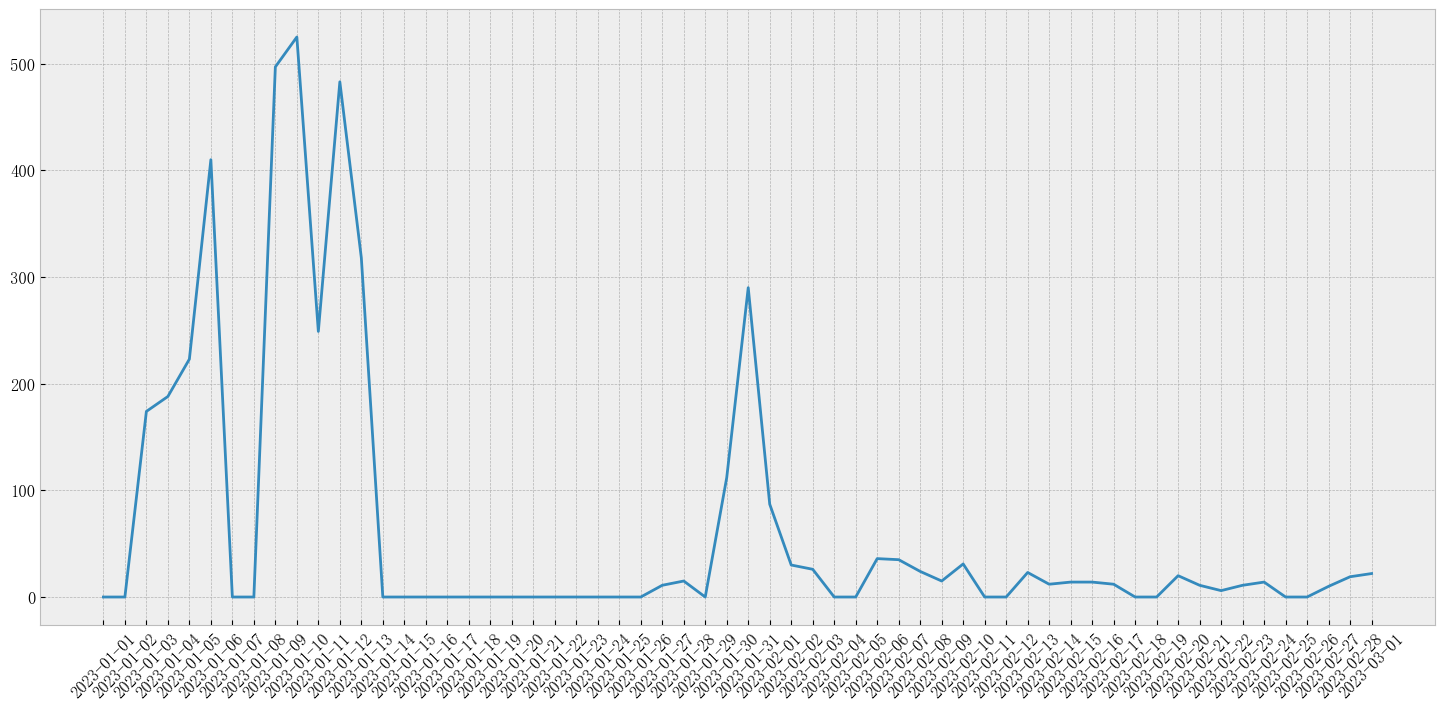

In [17]:
plt.plot(df_test["离职人数"][:60])

# Your code for creating the plot
# ...

# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [18]:
# ADD time features to our model
def create_time_features(df, target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = pd.to_datetime(df.index)
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    # df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [19]:
X_train_df, y_train = create_time_features(
    df_training, target='离职人数')
X_test_df, y_test = create_time_features(df_test, target='离职人数')
# scaler = StandardScaler()
# scaler.fit(X_train_df)  # No cheating, never scale on the training+test!
# X_train = scaler.transform(X_train_df)
# X_test = scaler.transform(X_test_df)

# X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
# X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

## lightgbm迭代训练
2018-01-01 ~ 2023-07-31 作为base模型，预测未来1天的数据；然后迭代训练未来1天

In [20]:
for i in range(len(df_test)):
    lightGBM = lgb.LGBMRegressor()
    X_train_data = pd.concat([X_train_df, X_test_df[:i]], ignore_index=True)
    y_train_data = pd.concat([y_train,y_test[:i]])

    lightGBM.fit(X_train_data.values, y_train_data)
    yhat = lightGBM.predict(X_test_df.values[i:i+1])
    yhat = np.round(yhat)
    yhat[yhat < 0] = 0   
    # resultsDict[f'Lightgbm_{i}'] = evaluate(df_test["离职人数"][i:i+1], yhat)
    predictionsDict["Lightgbm"].extend(yhat.tolist())



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 823
[LightGBM] [Info] Number of data points in the train set: 364, number of used features: 15
[LightGBM] [Info] Start training from score 150.277473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [21]:
evaluate(df_test["离职人数"], predictionsDict["Lightgbm"])

{'mae': 42.394520547945206,
 'rmse': 75.10511355554813,
 'mape': 60054794522.07789,
 'r2': 0.5255377371997497}

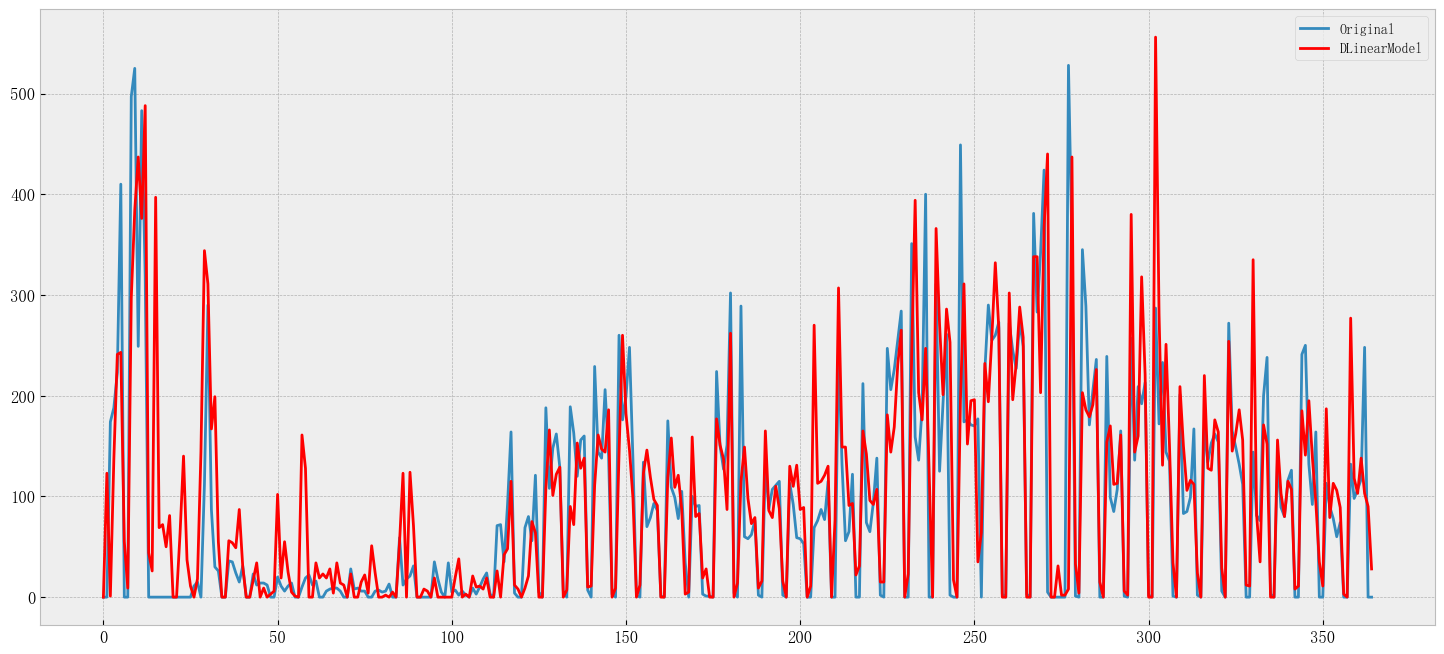

In [22]:
plt.plot(df_test["离职人数"].values, label='Original')
plt.plot(predictionsDict["Lightgbm"], color='red', label='DLinearModel')
plt.legend()

## XGBOOST

In [23]:
import xgboost as xgb
for i in range(len(df_test)):
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    X_train_data = pd.concat([X_train_df, X_test_df[:i]], ignore_index=True)
    y_train_data = pd.concat([y_train,y_test[:i]])
    xgb_model.fit(X_train_data.values, y_train_data)
    yhat = xgb_model.predict(X_test_df.values[i:i+1])
    yhat = np.round(yhat)
    yhat[yhat < 0] = 0
    yhat[yhat>df_training["离职人数"].max()] = df_training["离职人数"].max()
    resultsDict[f'xgb_{i}'] = evaluate(df_test["离职人数"][i:i+1], yhat)
    predictionsDict["xgboost"].extend(yhat.tolist())



In [24]:
evaluate(df_test["离职人数"], predictionsDict["xgboost"])

{'mae': 46.90684931506849,
 'rmse': 91.92407528193229,
 'mape': 69945205481.08861,
 'r2': 0.28924290924059426}

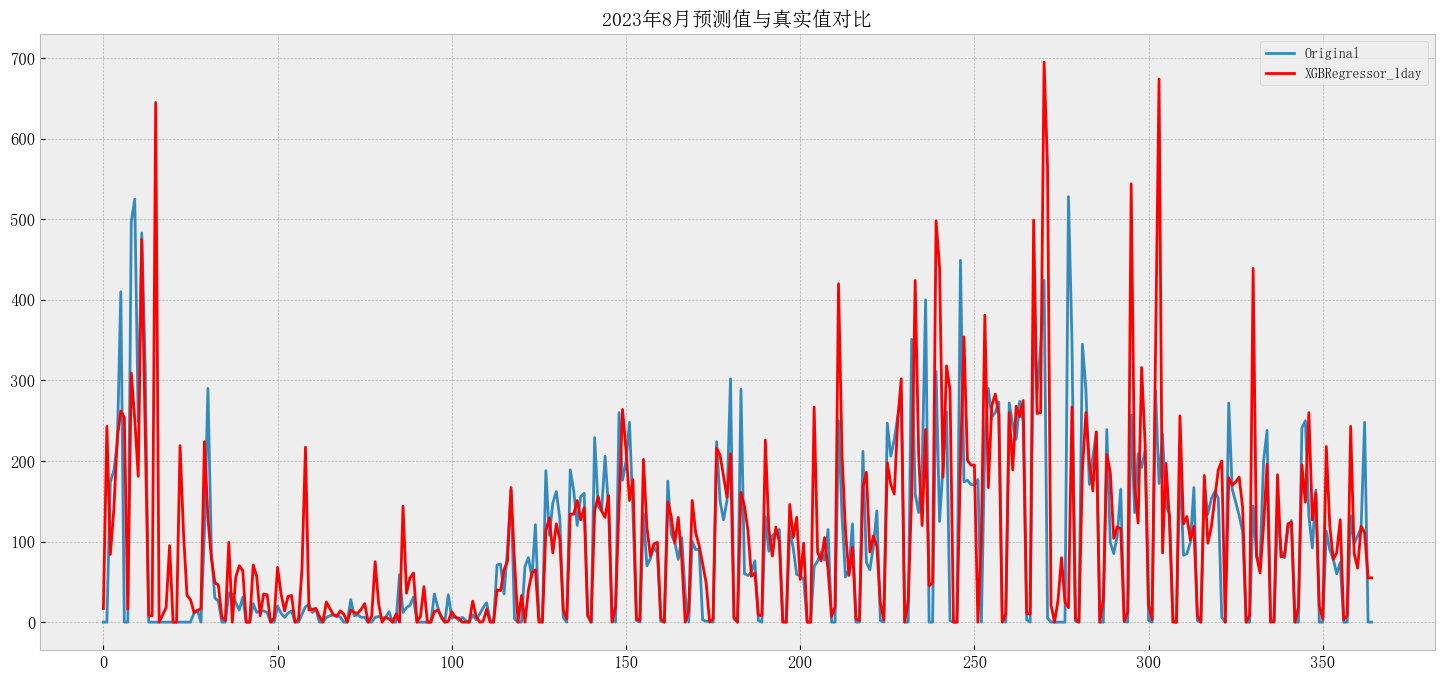

In [25]:
plt.plot(df_test["离职人数"].values, label='Original')
plt.plot(predictionsDict["xgboost"], color='red', label='XGBRegressor_1day')
plt.title("2023年8月预测值与真实值对比")
plt.legend()

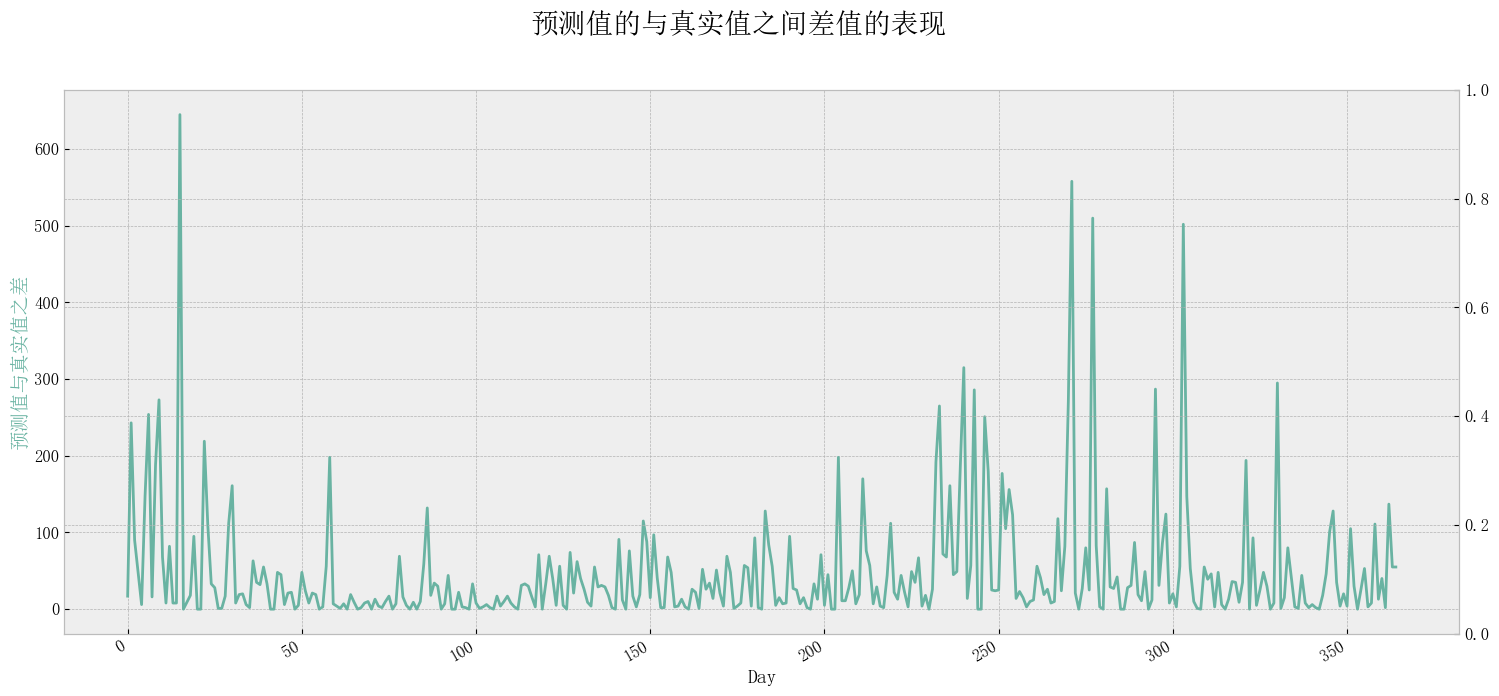

In [26]:
residuals = df_test["离职人数"].values - predictionsDict["xgboost"]
# residuals_rate = abs(residuals) /  df_test["离职人数"].values
# residuals_rate[residuals_rate>1] = 1

# 创建图表
fig, ax1 = plt.subplots()

# 添加第二个y轴
ax2 = ax1.twinx()

# 绘制数据
ax1.plot(abs(residuals), color="#69b3a2", lw=2)
# ax2.plot(df_test["离职人数"].values, color="#3399e6", lw=2)

# 设置轴标签和标题
ax1.set_xlabel("Day")
ax1.set_ylabel("预测值与真实值之差", color="#69b3a2", fontsize=14)
# ax2.set_ylabel("预测值与真实值之差的比例", color="#3399e6", fontsize=14)
fig.suptitle("预测值的与真实值之间差值的表现", fontsize=20)
# 设置两个y轴的坐标分度相同
# a, b = 0, 1200  # 设置y轴坐标范围
# ax1.set_ylim(a, b)
# ax2.set_ylim(a, b)
# 自定义日期标签格式
fig.autofmt_xdate()


# for i,v in  enumerate(residuals):
#     ax1.text(i,v,str(v)+"/"+str(df_test["离职人数"].values[i]))
# ax1.axhspan(-200,200,alpha = 0.5,color = "red")

# plt.plot(residuals)
# plt.axhline(y = 200,color = "red")
# plt.axhline(y = -200,color = "red")
# for i,v in  enumerate(residuals):
#     plt.text(i,v,str(v)+"/"+str(df_test["离职人数"].values[i]))
# plt.axhspan(-200,200,alpha = 0.5,color = "red")
# plt.title("每天的预测值与真实值之间的差值")

<Axes: >

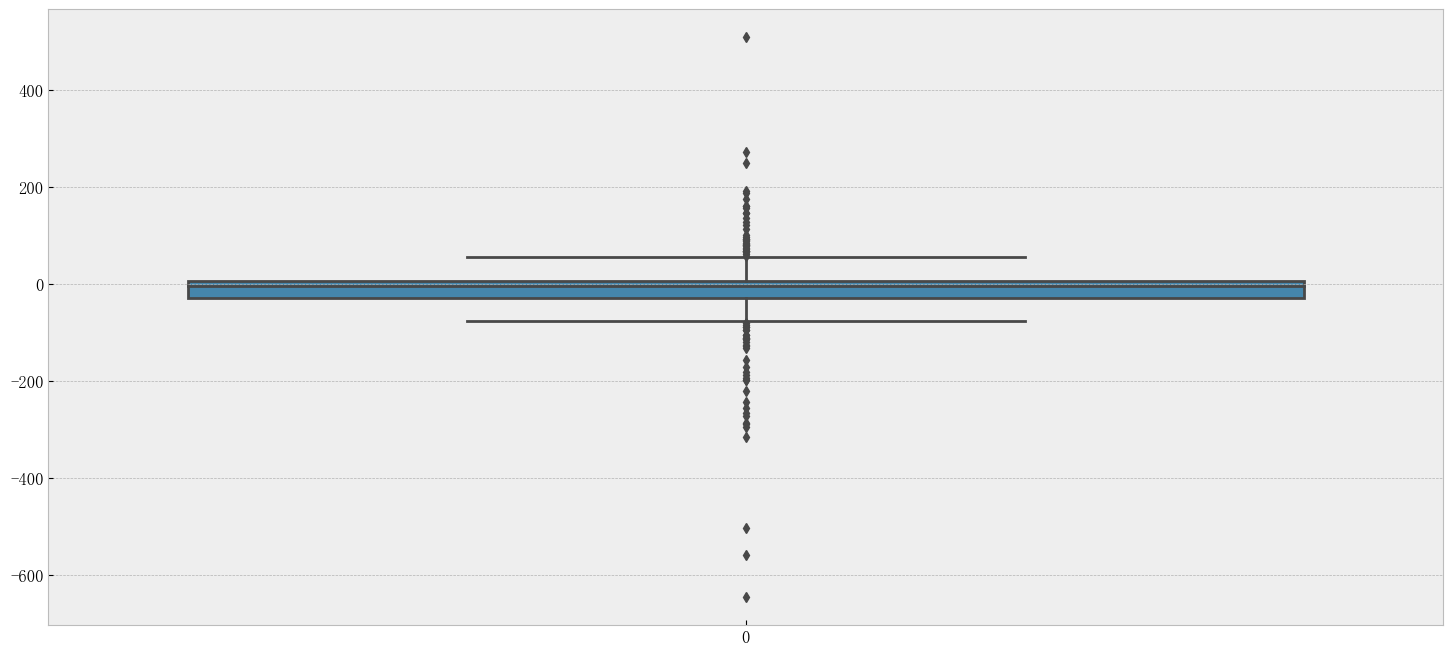

In [27]:
import seaborn as sns
sns.boxplot(residuals)

In [28]:
res = pd.DataFrame(columns=["预测值与真实值相差绝对值","真实离职人数",])
for i in range(0,31):
    # 创建一个新的数据行
    new_row = {'预测值与真实值相差绝对值': residuals_abs[i], '真实离职人数': df_test["离职人数"].values[i], }  # 用实际的列名和值替换 value1, value2, ...

    # 将新的数据行添加到数据框中
    res.loc[len(res)] = new_row
res

NameError: name 'residuals_abs' is not defined

In [ ]:
res.to_csv("example.csv",index=False,encoding="utf-8-sig")

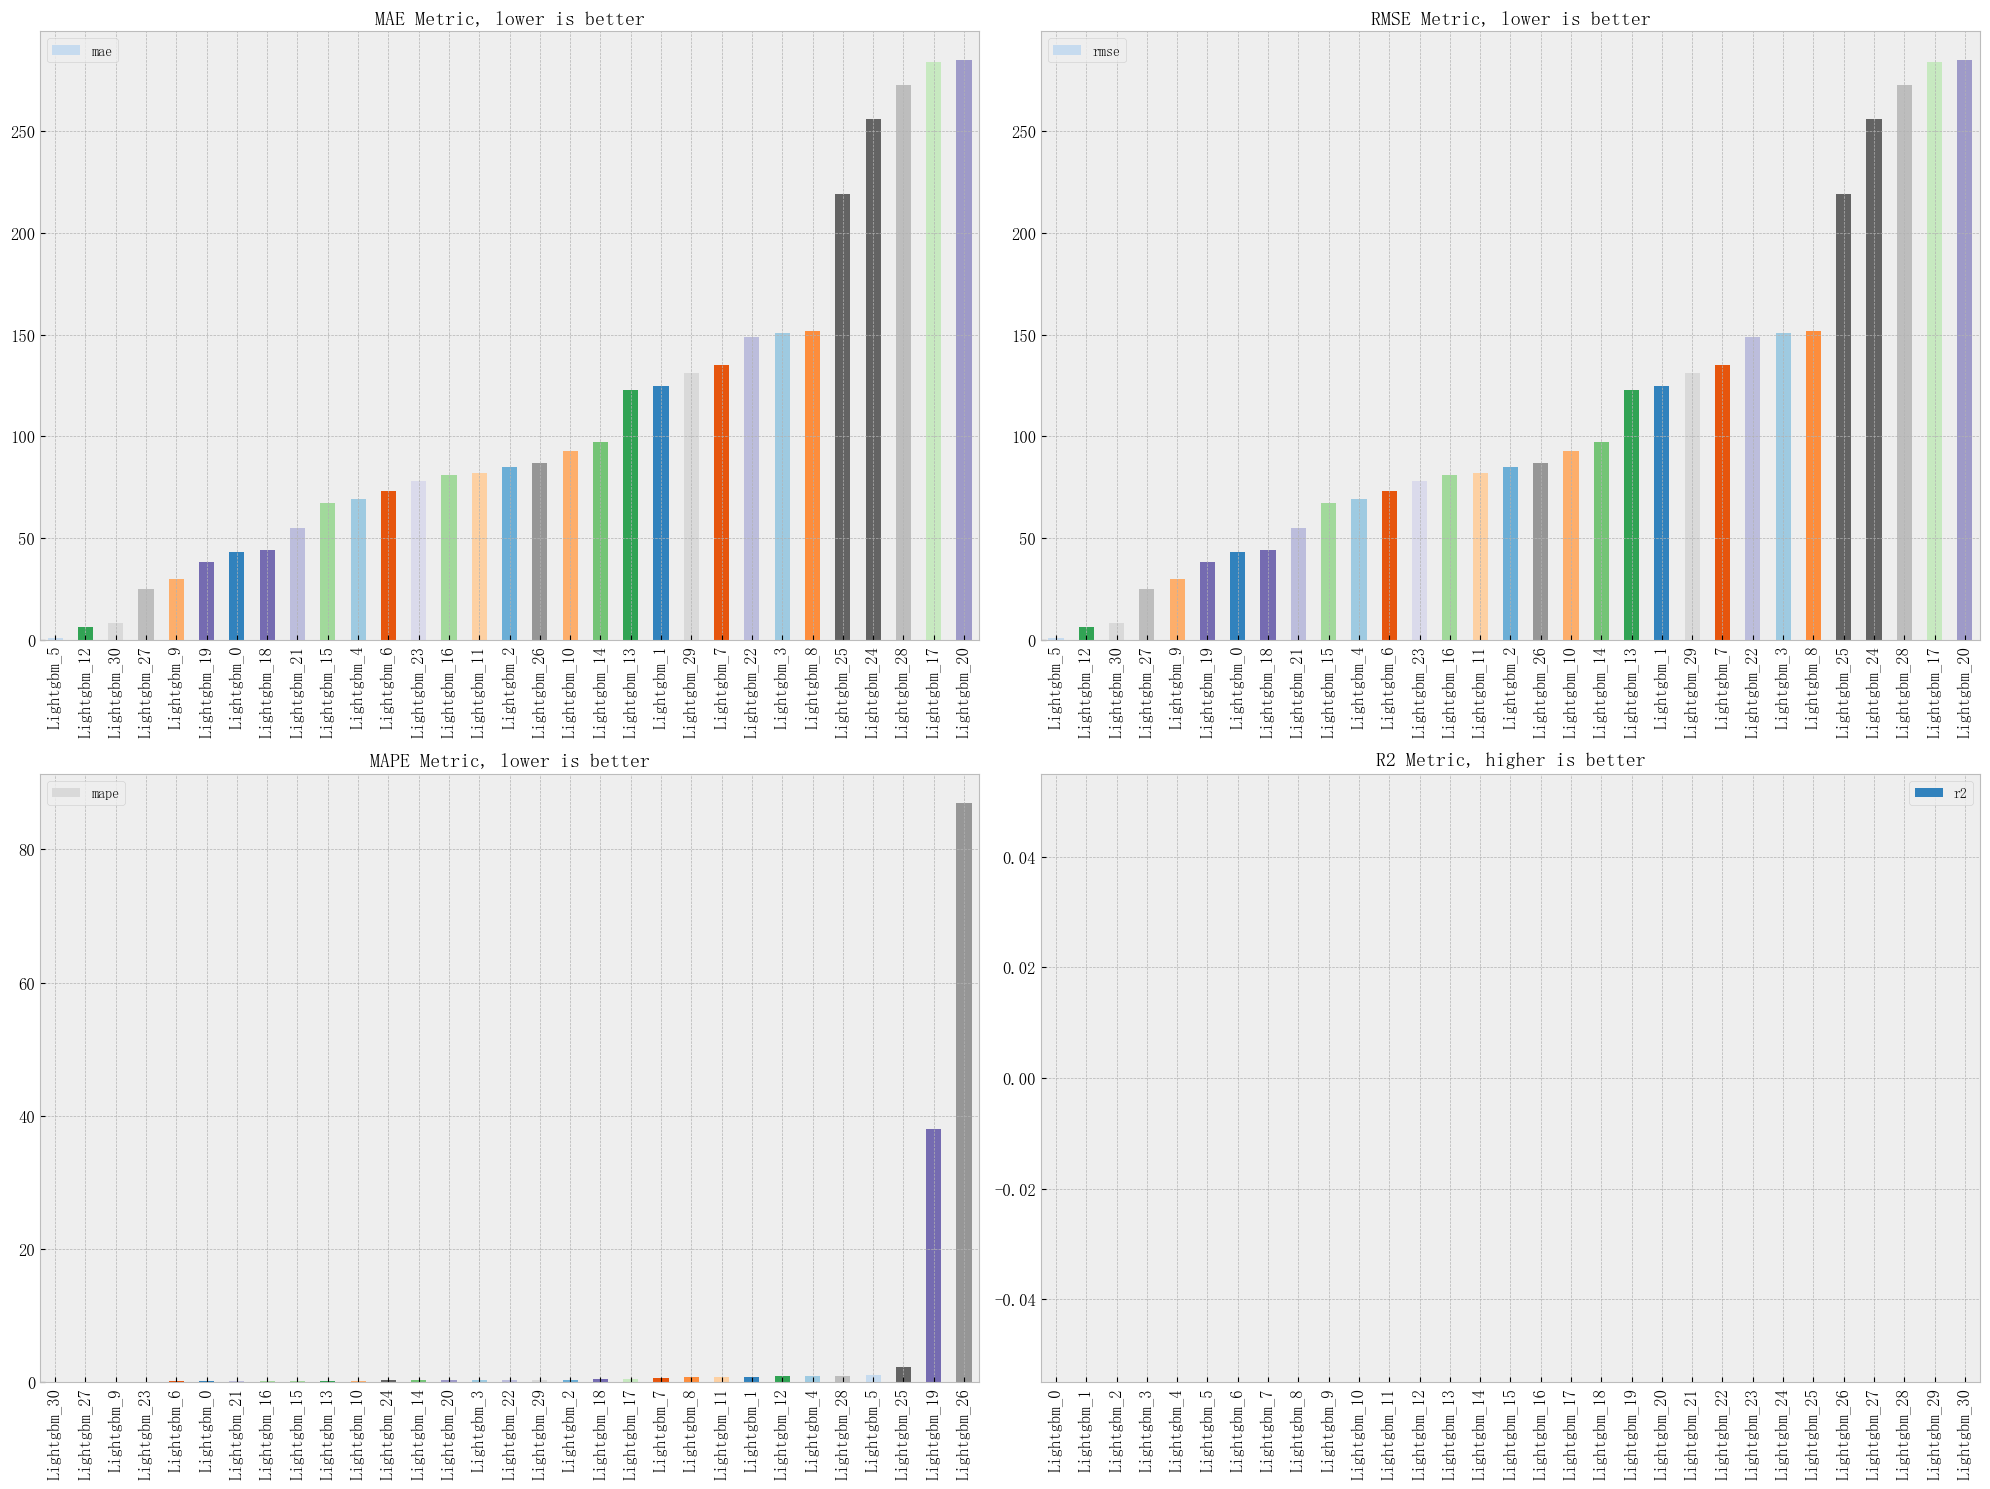

In [ ]:
bar_metrics(resultsDict)